In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_row', 100)
pd.set_option('display.max_info_columns', 100)


    - Datafield
    - DBNOs(Down But Not Out)   적을 기절시켰으나, 적 팀원에 의해 부활되어 실제로는 킬로 처리되지 않은 횟수
    - assists                   아군이 킬했을 때 같이 데미지를 넣은 수 (말 그대로 어시스트)
    - boosts                    부스트 아이템 사용 횟수
    - damageDealt               총 넣은 데미지 (단, 팀에 준 피해나 자해는 포함되지 않음)
    - headshotKills             헤드샷 킬 수
    - heals                     힐링 아이템 사용 횟수
    - Id                        플레이어 ID
    - killPlace                 매치에서의 킬수만 따졋을때 순위
    - killPoints                킬 수로 산정한 ELO의 개념. rankpoints가 없다면 killPoints가 존재 
    - killStreaks               짧은 시간동안 최대한 많이 킬했을 때의 킬 수 / 죽지않고 킬을 했을때 
    - kills                     총 킬 수
    - longestKill               킬과 킬 사이의 이동한 가장 긴 거리
    - matchDuration             매치의 시간 (초 단위)   -> 맵 사이즈에 따른 시간이 다르다 (평균 : 30분, 23분 )
    - matchId                   매치 ID (트레이닝 데이터와 테스트 데이터에 동일한 매치 ID는 없음)
    - matchType                 매치 타입 “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; 
                                나머지는 이벤트 또는 커스텀 매치
    - rankPoints                랭킹 ELO의 개념
    - revives                   아군 부활 횟수
    - rideDistance              탈것으로 이동한 총 거리
    - roadKills                 탈것으로 킬한 횟수
    - swimDistance              수영한 총 거리
    - teamKills                 팀킬 횟수
    - vehicleDestroys           차량 폭파 횟수
    - walkDistance              걸어간 총 거리 total : 3 map 
                                -> map 2개 : 8 X 8 km => 최대 대각선 길이 : 11.3km
                                   map 1개 : 4 X 4 km => 최대 대각선 길이 : 5.6km
    - weaponsAcquired           얻은 무기의 수
    - winPoints                 승리 횟수로 판단한 ELO의 개념
    - groupId                   매치 내 그룹 아이디, 동일 그룹 구성원들이 다른 게임을 할 때마다 
                                새로운 그룹 아이디가 부여됨
    - numGroups                 게임 내 총 그룹 수 (솔로 -> 듀오 -> 스쿼드로 갈 수록 줄어듦)
    - maxPlace                  한 경기내 최하 등수()
    - winPlacePerc              예측 목표, 1에 가까워질 수록 순위가 높아진다. 
                                (0부터 1까지의 값으로 나타냄. 1은 1등을, 0은 꼴등을 의미한다.)
                                (maxPlace-winPlace)/(maxPlace-1) = winPlacePerc
                                즉, 경기에 들어온 팀수에 따라 경기 등수가 결정된다.

## 사전 지식 전달 사항

- 기본 게임 진행 방식 : 

- 우승 조건 :

- 기타 : 

## 기본 사항

In [21]:
# 이벤트 메치 드랍된 자료 사용
data_path = 'C:/Users/hojun/Documents/dev/Kaggle-PUBG/'
df = pd.read_csv(data_path+'event_drop.csv')

In [22]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [23]:
# df = reduce_mem_usage(df)

## drop

In [24]:
# drop 확인을 위한 DataFrame 생성
drop_proof_df = df.copy()

### drop event game 

In [25]:
# drop_event = ['crashfpp', 'flaretpp', 'flarefpp', 'crashtpp']
# for i in drop_event:
#     indexNames = df[df['matchType'].str.contains(i)].index
#     df.drop(indexNames,  inplace=True)


#### 이유

전체 데이터의 0.1%도 차지하지 않는 데이터양과 이상치, 특이한 방식의 게임 운영으로 이벤트 경기는 제외

### drop columns

#### 'killPoints', 'winPoints', 'rankPoints' drop

In [26]:
drop_columns = ['killPoints', 'winPoints', 'rankPoints']
df.drop(columns=drop_columns, inplace=True)

##### 이유 

'killPoints', 'winPoints', 'rankPoints' 상관관계도로 확인

결과에 의한 수치들을 계산한 값으로써 너무 높은 영향(leakage)를 확인하여 제외

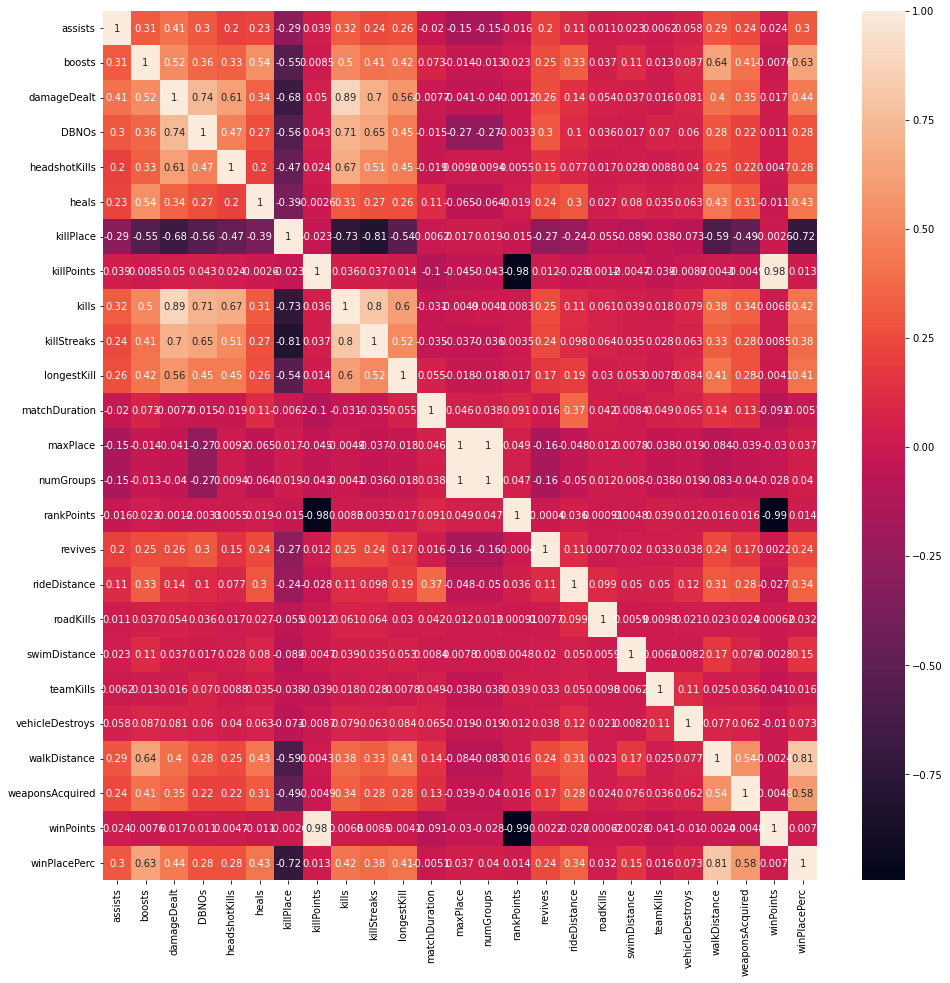

In [27]:
plt.figure(figsize=(16, 16))
sns.heatmap(data=drop_proof_df.corr(), annot=True)
plt.show()

#### 'numGroups' drop

In [28]:
df.drop(columns='numGroups', inplace=True)

##### 이유

- 예측값 : 1 (1등)의 이동 거리 분포 확인

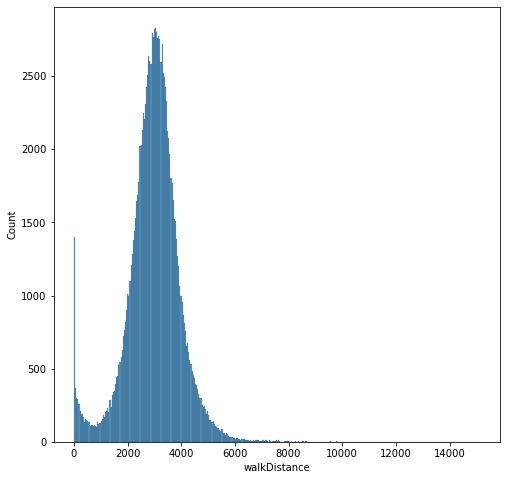

In [29]:
wpp_1 =drop_proof_df[drop_proof_df['winPlacePerc'] == 1]['walkDistance']
plt.figure(figsize=(8, 8))
sns.histplot(data=drop_proof_df, x=wpp_1 )
plt.show()

- 1등인데 이동거리가 0인 data 확인

In [30]:
drop_proof_df[(drop_proof_df['winPlacePerc'] == 1) & (drop_proof_df['walkDistance']==0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
3692,3fc123559fc935,5cef1df7ee3551,01aead02bb8901,0,0,0.0000,0,0,0,1,0,0,0,0.00,1808,solo,20,2,1500,0,0.0,0,0.0,0,0,0.0,3,0,1.0
8770,106afdb574db25,4b0ae4659e9936,cf0cb51c829eb5,0,0,0.0000,0,0,0,2,0,0,0,0.00,1808,solo,18,2,1500,0,0.0,0,0.0,0,0,0.0,1,0,1.0
9243,0351565a7058e9,3663a93a319725,3659fe3694262a,0,0,0.3218,0,0,0,1,0,0,0,0.00,1808,solo,18,2,1500,0,0.0,0,0.0,0,0,0.0,9,0,1.0
18378,e6d6f94558dd2f,22818b9a9a6159,486200c5613f14,0,1,0.0000,0,0,0,2,0,0,0,0.00,1808,solo,19,2,1500,0,0.0,0,0.0,0,0,0.0,6,0,1.0
19006,d0683f5d780f09,faebf5c484de4a,ec9a90395ed8c0,0,0,99.0000,0,0,0,1,0,0,0,0.00,1808,solo,17,2,1500,0,0.0,0,0.0,0,0,0.0,9,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419845,6cc9d7b1643cbd,11fce60d5c8ea3,60c6e90b964266,3,0,645.6000,6,1,0,28,0,5,2,57.58,1216,normal-squad-fpp,6,6,1500,2,0.0,0,0.0,0,0,0.0,31,0,1.0
4420599,69f2d577afb916,1ca82eb3229fe3,8b1af8b54b0edb,0,0,0.0000,0,0,0,2,0,0,0,0.00,1808,solo,18,2,1500,0,0.0,0,0.0,0,0,0.0,0,0,1.0
4422414,87a4d46be07ec6,7921c8beb38c2d,2183f03b8dd456,0,3,115.6000,0,0,1,2,0,0,0,0.00,1808,solo,20,2,1500,0,0.0,0,0.0,0,0,0.0,6,0,1.0
4433367,120b7d2d32663f,b70109a45eb127,6db87452a2db21,0,0,0.0000,0,0,0,2,0,0,0,0.00,1808,solo,17,2,1500,0,0.0,0,0.0,0,0,0.0,3,0,1.0


In [31]:
drop_proof_df[drop_proof_df['matchId']=='01aead02bb8901'][['groupId', 'damageDealt', 'kills', 'killPlace', 'matchType','maxPlace','numGroups','walkDistance','weaponsAcquired','winPlacePerc']]

,groupId,damageDealt,kills,killPlace,matchType,maxPlace,numGroups,walkDistance,weaponsAcquired,winPlacePerc
3692,5cef1df7ee3551,0.00,0,1,solo,20,2,0.0,3,1.0
52397,c70fd467685d53,178.50,0,16,solo,20,2,0.0,3,0.0
152554,5cef1df7ee3551,0.00,0,4,solo,20,2,592.9,5,1.0
230675,c70fd467685d53,0.00,0,11,solo,20,2,0.0,3,0.0
312980,5cef1df7ee3551,119.40,0,3,solo,20,2,0.0,8,1.0
449983,c70fd467685d53,78.00,0,10,solo,20,2,0.0,3,0.0
762729,c70fd467685d53,0.00,0,20,solo,20,2,0.0,0,0.0
1319387,c70fd467685d53,0.00,0,18,solo,20,2,0.0,7,0.0
1688326,c70fd467685d53,159.00,0,9,solo,20,2,0.0,5,0.0
1839645,5cef1df7ee3551,0.00,0,2,solo,20,2,0.0,3,1.0


    - 수치상 불가능한 data (이동거리 없이 무기획득 등) 확인  되어 제외

- maxPlace(경기당 마지막 등수)와 numGroups(경기 참가팀수)가 다른 경기들 확인

In [33]:
temp_df = drop_proof_df[drop_proof_df.maxPlace != drop_proof_df.numGroups].sort_values(by=['numGroups','matchId'])[['winPlacePerc', 'numGroups', 'maxPlace', 'matchId']]
temp_df 

,winPlacePerc,numGroups,maxPlace,matchId
337842,0.0000,1,18,07baf6b1ba3de9
671026,0.0000,1,18,07baf6b1ba3de9
1056287,0.0000,1,18,07baf6b1ba3de9
1664753,0.0000,1,18,07baf6b1ba3de9
2046163,0.0000,1,18,07baf6b1ba3de9
...,...,...,...,...
4291031,0.5455,99,100,fe1be8e33af055
4295868,0.1717,99,100,fe1be8e33af055
4334803,0.3737,99,100,fe1be8e33af055
4370186,0.7980,99,100,fe1be8e33af055


- numGroups : 1 인 경우 예측값이 0으로 된다.

    -> numGroups : 1 인 경우 제외


In [34]:
temp_df.head(18)

,winPlacePerc,numGroups,maxPlace,matchId
337842,0.0,1,18,07baf6b1ba3de9
671026,0.0,1,18,07baf6b1ba3de9
1056287,0.0,1,18,07baf6b1ba3de9
1664753,0.0,1,18,07baf6b1ba3de9
2046163,0.0,1,18,07baf6b1ba3de9
2220777,0.0,1,18,07baf6b1ba3de9
2273755,0.0,1,18,07baf6b1ba3de9
2318787,0.0,1,18,07baf6b1ba3de9
2394697,0.0,1,18,07baf6b1ba3de9
2494260,0.0,1,18,07baf6b1ba3de9


In [35]:
temp_df[temp_df['numGroups']==1]['winPlacePerc'].unique()

array([0.])

numGroups과 maxPlace가 일치하지 않는 경우 확인

- maxPlace : 3 이하인 경우는 없었고

- maxPlace의 value와 winPlacePerc(예측값)의 분할갯수가 일치하였고 

    -> numGroups는 일치하지 않는 경우가 있어서 numGroups는 제외

In [36]:
temp_df[temp_df['maxPlace'] <=3]

,winPlacePerc,numGroups,maxPlace,matchId


In [37]:
temp_df[temp_df['numGroups']==5]['winPlacePerc'].unique()

array([0.8   , 0.6   , 0.2   , 1.    , 0.    , 0.4   , 0.625 , 0.25  ,
       0.5   , 0.7143, 0.4286, 0.1429, 0.8333, 0.3333])

In [38]:
temp = []
for i in range(4, 101):
    temp.append([i, temp_df[temp_df['maxPlace']==i]['winPlacePerc'].nunique()])
print(temp)

[[4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10], [11, 11], [12, 12], [13, 13], [14, 14], [15, 15], [16, 16], [17, 17], [18, 18], [19, 19], [20, 20], [21, 21], [22, 22], [23, 23], [24, 24], [25, 25], [26, 26], [27, 27], [28, 28], [29, 29], [30, 30], [31, 31], [32, 32], [33, 33], [34, 34], [35, 35], [36, 36], [37, 37], [38, 38], [39, 39], [40, 40], [41, 41], [42, 42], [43, 43], [44, 44], [45, 45], [46, 46], [47, 47], [48, 48], [49, 49], [50, 50], [51, 51], [52, 52], [53, 44], [54, 54], [55, 55], [56, 55], [57, 57], [58, 57], [59, 52], [60, 60], [61, 60], [62, 62], [63, 50], [64, 64], [65, 65], [66, 66], [67, 64], [68, 68], [69, 69], [70, 70], [71, 71], [72, 69], [73, 73], [74, 74], [75, 75], [76, 76], [77, 77], [78, 78], [79, 79], [80, 80], [81, 81], [82, 82], [83, 83], [84, 84], [85, 85], [86, 86], [87, 87], [88, 88], [89, 89], [90, 90], [91, 91], [92, 92], [93, 93], [94, 94], [95, 95], [96, 96], [97, 97], [98, 98], [99, 99], [100, 100]]


In [39]:
# 확인용 DataFrame 삭제
del temp_df
del drop_proof_df
gc.collect()

2040

### drop isna True

- 예측값 결측치가 있는 경기 drop

In [40]:
df[df['winPlacePerc'].isna()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc
2738537,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,0,0,0.0,9,solo-fpp,1,0,0.0,0,0.0,0,0,0.0,0,NaN


In [41]:
df.drop(index=df[df['matchId']== '224a123c53e008'].index, inplace=True)

### drop 경기인원 이하 (custom game) - 추가 가능 좀비모드 그래프 추가

#### 이유

- 경기 인원이 일정 이하인 경우 : 이동거리, 무기획득이 너무 높은 수치가 나와서 결과값 예측에 방해가 된다.

In [42]:
df[(df.maxPlace <= 5) & (df.winPlacePerc == 0)][['weaponsAcquired', 'walkDistance', 'winPlacePerc', 'maxPlace']]

,weaponsAcquired,walkDistance,winPlacePerc,maxPlace
20333,3,3033.0,0.0,4
22365,6,841.4,0.0,4
33176,12,0.0,0.0,2
41148,17,2400.0,0.0,3
51253,2,129.3,0.0,2
...,...,...,...,...
4426104,17,614.2,0.0,5
4428841,22,784.4,0.0,3
4431020,8,0.0,0.0,2
4431219,13,186.6,0.0,2


In [43]:
df[df.maxPlace <= 5]['matchType'].value_counts()

normal-squad-fpp    1319
normal-duo-fpp       211
normal-squad         138
squad-fpp             65
normal-duo            20
duo-fpp               15
normal-solo-fpp       10
Name: matchType, dtype: int64

- 대부분이 normal 경기이고 해당 수치와 normal 경기에서 발견되는 각종 이상치들 확인
- 전체 경기 중 차지 비율이 낮으므로 제외

    - normal 경기 제외

In [44]:
df = df.drop(index=df[df['matchType'].str.contains('normal')].index)

In [45]:
df[(df.maxPlace >= 6) &(df.maxPlace <= 10) & (df.winPlacePerc == 0)][['weaponsAcquired', 'walkDistance', 'winPlacePerc', 'maxPlace']]

,weaponsAcquired,walkDistance,winPlacePerc,maxPlace
254298,1,118.600,0.0,7
283360,3,533.800,0.0,8
378858,0,0.000,0.0,10
398634,1,36.290,0.0,10
653482,2,35.390,0.0,7
680701,3,57.320,0.0,10
1005322,0,0.000,0.0,10
1061705,1,30.520,0.0,10
1123819,0,29.870,0.0,7
1219599,2,26.890,0.0,10


## 핵 사용 유저 선별 및 제거 함수 

In [46]:
def hack_user_drop(df):
    hack_users = pd.DataFrame()
    ### Anomalies in roadKills ###
    df.drop(df[df['roadKills'] >= 5].index, inplace=True)
    ### Anomalies in aim 1 (More than 50 kills) ###
    df.drop(df[df['kills'] >= 40].index, inplace=True)
    ## Anomalies in aim 2 (More than 10 Headshotkills)
    df.drop(df[df['headshotKills'] >= 15].index, inplace=True)
    ### Anomalies in aim 3 (80% headshot_rate & More than 10 kills) ###
    df['headshot_rate'] = df['headshotKills'] / df['kills']
    df['headshot_rate'] = df['headshot_rate'].fillna(0)
    df.drop(df[(df['headshot_rate'] >= 0.8) & (df['kills'] > 10)].index , inplace=True)
    ### Anomalies in aim 3 (Longest kill) ###
    df.drop(df[df['longestKill'] >= 1000].index, inplace=True)
    ### Anomalies in aim 3 (More than 20 DBNo) ###
    df.drop(df[df['DBNOs'] >= 20].index, inplace=True)
    ### Anomalies in movement ###
    # walkDistance anomalies
    df.drop(df[df['walkDistance'] >= 10000].index, inplace=True)
    # rideDistance anomalies
    df.drop(df[df['rideDistance'] >= 25000].index, inplace=True)
    # swimDistance anomalies
    df.drop(df[df['swimDistance'] >= 1500].index, inplace=True)
    ### Anomalies in item 1 (weaponsAcquired) ###
    df.drop(df[df['weaponsAcquired'] >= 50].index, inplace=True)
    ### Anomalies in item 2 (heals) ###
    df.drop(df[df['heals'] >= 40].index, inplace=True)
    ### Anomalies in item 3 (boosts) ###
    df.drop(df[df['boosts'] >= 15].index, inplace=True)
    ## ETC ##
    # drop savage killer (kill streak >= 10)
    df.drop(df[df['killStreaks'] >= 10].index ,inplace=True)
    # revive zombies (revives >= 10)
    df.drop(df[df['revives'] >= 10].index ,inplace=True)
    #Weapon master (weaponsAcquired >= 50)
    df.drop(df[df['weaponsAcquired'] >= 50].index ,inplace=True)
    #team killer = troll ( teamkills > 4)
    df.drop(df[df['teamKills'] >= 50].index ,inplace=True)
    # Strange road killer (roadKills>= 5)
    df.drop(df[df['roadKills'] >= 5].index, inplace=True)
    # Too little walkDistance
    df.drop(df[(df['walkDistance']<=10.0) & (df['damageDealt'] >= 1000)].index, inplace=True)
    df.drop(df[(df['walkDistance']<=10.0) & (df['kills'] >= 5)].index, inplace=True)
    df.drop(df[(df['walkDistance']<=10.0) & (df['heals'] >= 5)].index, inplace=True)
    df.drop(df[(df['walkDistance']<=10.0) & (df['headshotKills'] >= 5)].index, inplace=True)
    df.drop(df[(df['walkDistance']==0) & (df['winPlacePerc'] == 1)].index, inplace=True)
    # superman ?
    df.drop(df[(df['damageDealt'] >=1500) & (df['kills'] >= 15) & (df['heals'] == 0)].index, inplace=True)
    # Maybe cheater & Gosu
    df.drop(df[(df['damageDealt'] >=2500) & (df['kills'] >= 25)].index, inplace=True)
    return df

In [47]:

def hack_users(df):
    hack_users = pd.DataFrame()
    ### Anomalies in roadKills ###
    hack_users = pd.concat([hack_users, df[df['roadKills'] >= 5]])
    ### Anomalies in aim 1 (More than 50 kills) ###
    hack_users = pd.concat([hack_users, df[df['kills'] >= 40]])
    ## Anomalies in aim 2 (More than 10 Headshotkills)
    hack_users = pd.concat([hack_users, df[df['headshotKills'] >= 15]])
    ### Anomalies in aim 3 (80% headshot_rate & More than 10 kills) ###
    df['headshot_rate'] = df['headshotKills'] / df['kills']
    df['headshot_rate'] = df['headshot_rate'].fillna(0)
    hack_users = pd.concat([hack_users, df[(df['headshot_rate'] >= 0.8) & (df['kills'] > 10)]])
    ### Anomalies in aim 3 (Longest kill) ###
    hack_users = pd.concat([hack_users, df[df['longestKill'] >= 1000]])
    ### Anomalies in aim 3 (More than 20 DBNo) ###
    hack_users = pd.concat([hack_users, df[df['DBNOs'] >= 20]])
    ### Anomalies in movement ###
    # walkDistance anomalies
    hack_users = pd.concat([hack_users, df[df['walkDistance'] >= 10000]])
    # rideDistance anomalies
    hack_users = pd.concat([hack_users, df[df['rideDistance'] >= 25000]])
    # swimDistance anomalies
    hack_users = pd.concat([hack_users, df[df['swimDistance'] >= 1500]])
    ### Anomalies in item 1 (weaponsAcquired) ###
    hack_users = pd.concat([hack_users, df[df['weaponsAcquired'] >= 50]])
    ### Anomalies in item 2 (heals) ###
    hack_users = pd.concat([hack_users, df[df['heals'] >= 40]])
    ### Anomalies in item 3 (boosts) ###
    hack_users = pd.concat([hack_users, df[df['boosts'] >= 15]])
    ## ETC ##
    # drop savage killer (kill streak >= 10)
    hack_users = pd.concat([hack_users, df[df['killStreaks'] >= 10]])
    # revive zombies (revives >= 10)
    hack_users = pd.concat([hack_users, df[df['revives'] >= 10]])
    #Weapon master (weaponsAcquired >= 50)
    hack_users = pd.concat([hack_users, df[df['weaponsAcquired'] >= 50]])
    #team killer.append(troll ( teamkills > 4)
    hack_users = pd.concat([hack_users, df[df['teamKills'] >= 50]])
    # Strange road killer (roadKills>= 5)
    hack_users = pd.concat([hack_users, df[df['roadKills'] >= 5]])
    # Too little walkDistance
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['damageDealt'] >= 1000)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['kills'] >= 5)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['heals'] >= 5)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['headshotKills'] >= 5)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']==0) & (df['winPlacePerc'] == 1)]])
    # superman ?
    hack_users = pd.concat([hack_users, df[(df['damageDealt'] >=1500) & (df['kills'] >= 15) & (df['heals'] == 0)]])
    # Maybe cheater & Gosu
    hack_users = pd.concat([hack_users, df[(df['damageDealt'] >=2500) & (df['kills'] >= 25)]])
    return hack_users

## 핵 유저 관련 feature 생성

In [48]:
# hack_user_drop(df)
# df.drop(columns='headshot_rate', inplace=True)

- 핵사용 유저 확인 (핵 중복 사용 유저 정리 포함)

In [49]:
hack_user = hack_users(df)
df.drop(columns='headshot_rate', inplace=True)
hack_user.drop(columns='headshot_rate', inplace=True)
hack_user = hack_user.drop_duplicates('Id') # 핵 중복 사용 유저 정리

In [50]:
hack_fuature_add_df = df.copy()

- 핵유저 포함 team 표시 feature 생성

In [51]:
hack_user_groupid = str(list(hack_user.groupId.values))

# -> 핵유저가 있는 팀 : 1   없는 팀 : 0
hack_fuature_add_df["hack_user_team"] = hack_fuature_add_df.groupId.apply(lambda x : 0 if hack_user_groupid.find(x)==-1 else 1) # find 함수는 찾지 못하면 -1 반환

- 핵유저 참여 game 표시 feature 생성

In [52]:
hack_user_matchid = str(list(hack_user.matchId.values))

# -> 핵유저가 참여한 경기 : 1   없는 팀 : 0
hack_fuature_add_df["hack_user_game"] = hack_fuature_add_df.matchId.apply(lambda x : 0 if hack_user_matchid.find(x)==-1 else 1) # find 함수는 찾지 못하면 -1 반환

In [53]:
# 핵유저 제거 확인
# set(list(hack_user['groupId'])) & set(list(hack_team_drop[hack_team_drop['hack_user_team']==0]['groupId']))

In [54]:
# 핵 유저가 참여한 경기 수
hack_game_count = round(hack_fuature_add_df.groupby('matchId')['hack_user_game'].agg(np.mean).sum())

print('핵유저수 :', hack_user.index.size, '\t\t\t',  '전체 참가인원 :', df.index.size, '\t','비율 :', round((hack_user.index.size/df.index.size*100), 3))
print('핵유저 포함 팀수 :', len(set(list(hack_user['groupId']))), '\t\t', '전체 참가팀수 :', len(set(list(df['groupId']))), '\t', '비율 :',round( len(set(list(hack_user['groupId'])))/len(set(list(df['groupId'])))*100 ,3))
print('핵유저팀 포함된 인원수 :', hack_fuature_add_df['hack_user_team'].sum(), '\t', '전체 참가인원 :', df.index.size, '\t','비율 :', round((hack_fuature_add_df['hack_user_team'].sum()/df.index.size*100), 3))
print('핵유저팀 포함된 경기수 :',hack_game_count,'\t', '전체 경기수 :', df.matchId.nunique(), '\t\t','비율 :', round((hack_game_count/df.matchId.nunique()*100), 3))

핵유저수 : 1810 			 전체 참가인원 : 4411698 	 비율 : 0.041
핵유저 포함 팀수 : 1343 		 전체 참가팀수 : 2014090 	 비율 : 0.067
핵유저팀 포함된 인원수 : 3419 	 전체 참가인원 : 4411698 	 비율 : 0.077
핵유저팀 포함된 경기수 : 1305 	 전체 경기수 : 47185 		 비율 : 2.766


### 핵유저가 포함된 경기들에서 핵유저가 거둔 성적 정리

In [55]:
# 핵유저가 포함된 팀과 경기
hack_team_include_team = hack_fuature_add_df[hack_fuature_add_df.hack_user_team == 1]
hack_team_include_game = hack_fuature_add_df[hack_fuature_add_df.hack_user_game == 1]

- 핵유저 포함 팀 또는 개인의 성적 확인 (우승 빈도, 전체 평균 성적)


In [56]:
hack_win_count = hack_user[hack_user['winPlacePerc']==1].drop_duplicates('Id').index.size
hack_win_count

1005

In [57]:
hack_game_count

1305

In [58]:
# 핵유저 개인 or 팀 우승 빈도
hack_win_count = hack_user[hack_user['winPlacePerc']==1].drop_duplicates('Id').index.size
print('핵유저 우승 횟수:', hack_win_count ,'\t\t', '핵유저 참여 경기수:', hack_game_count, '\t', '우승 확률 :', round(hack_win_count/hack_game_count*100, 3))

# 핵유저 개인 or 팀 평균 등수
hack_team_no_include = hack_fuature_add_df[hack_fuature_add_df.hack_user_team == 0]
print('핵유저팀 평균 등수 :', round(hack_team_include_team.winPlacePerc.values.mean(), 3), '\t', '일반 유저팀 평균 등수', round(hack_team_no_include.winPlacePerc.values.mean(), 3))
print('핵유저 평균 등수 :', round(hack_user.winPlacePerc.values.mean(), 3), '\t', '일반 평균 등수 :', round(hack_fuature_add_df.winPlacePerc.values.mean(), 3))


핵유저 우승 횟수: 1005 		 핵유저 참여 경기수: 1305 	 우승 확률 : 77.011
핵유저팀 평균 등수 : 0.771 	 일반 유저팀 평균 등수 0.472
핵유저 평균 등수 : 0.891 	 일반 평균 등수 : 0.473


In [59]:
# 팀별 평균 예상 : 0.5  실제 값 : 0.4998  
# hack_fuature_add_df.groupby('groupId')['winPlacePerc'].agg(np.mean).values.mean()

- 핵유저의 우승 확률이 77% 가 넘는 수치가 나옴
- 핵유저를 포함한 팀은 성적 상승
- 핵유저는 평균 등수 상승 
- 핵유저가 참석한 경기 -> 공정한 경기로 보기 어려움

#### 결과 : 핵유저가 참석한 경기와 같은 팀들의 상황을 분석하고 해당 경기 제외


## 핵유저가 없는 공평한 경기가 이루어졌을때를 전제로 프로젝트를 수행하겠다

In [60]:
hack_fuature_add_df = hack_fuature_add_df[hack_fuature_add_df.hack_user_game == 0]

In [61]:
hack_fuature_add_df.index.size

4316503

## data 분석을 위해 match type으로 data 분리

- categorical - nominal data => numerical
    - solo : 0, duo : 1, squad : 2

In [62]:
def divide_match_type(x):
    if x.find('solo') != -1:
        return 0
    elif x.find('duo') != -1:
        return 1
    else:
        return 2
hack_fuature_add_df['match_type_numerical'] = hack_fuature_add_df['matchType'].apply(lambda x : divide_match_type(x) )

In [63]:
hack_fuature_add_df[['matchType', 'match_type_numerical']].tail()

,matchType,match_type_numerical
4437079,squad-fpp,2
4437080,squad-fpp,2
4437081,solo,0
4437082,squad-fpp,2
4437084,solo-fpp,0


## 정규화 가능한 feature 정리 (미적용)

- 각 경기 100명 인원으로 가정하고 관련 column들 정규화
    - kills, damageDealt, maxPlace, matchDuration

In [64]:
def normalization(df):
    df['killsNorm'] = df['kills']*((100-df['playersJoined'])/100 + 1)
    df['damageDealtNorm'] = df['damageDealt']*((100-df['playersJoined'])/100 + 1)
    df['maxPlaceNorm'] = df['maxPlace']*((100-df['playersJoined'])/100 + 1)
    df['matchDurationNorm'] = df['matchDuration']*((100-df['playersJoined'])/100 + 1)

    for i in ['kills', 'damageDealt', 'maxPlace', 'matchDuration']:
        df.drop(columns=i, inplace=True)

# 팀전에서 데이터들을 평균으로 볼것인가? 합계로 볼것인가? 아니면 feature마다 나누어서 다르게 적용할것인가?

In [65]:
ㅁㄴㄹㅇㅁㄴㄻㄴㄹ

NameError: name 'ᄆᄂᄅᄋᄆᄂᆱᄂᄅ' is not defined

In [ ]:
# hack_fuature_add_df.to_csv(data_path+'hack_fuature_add_df.csv')
# hack_fuature_add_df = pd.read_csv(data_path+'hack_fuature_add_df.csv')

# Duo, Squad EDA

#### team data에 팀별로 groupby 하여 팀원수 column 추가

In [66]:
# 
hack_fuature_add_df['team_members'] = hack_fuature_add_df.groupby('groupId').Id.transform('count')

team_df_sum = hack_fuature_add_df[hack_fuature_add_df['hack_user_game']==0].iloc[:, :-5].groupby(['matchId', 'groupId']).agg(sum)
team_df_mean = hack_fuature_add_df[hack_fuature_add_df['hack_user_game']==0][['matchId', 'groupId','winPlacePerc', 'team_members', 'match_type_numerical', 'hack_user_team', 'hack_user_game']].groupby(['matchId', 'groupId']).agg(np.mean)

team_df = pd.concat([team_df_sum, team_df_mean], axis=1, ignore_index=False)

team_df = team_df[team_df['match_type_numerical'] != 0]


In [67]:
team_df

assists  boosts  damageDealt  DBNOs  \
matchId        groupId                                               
0000a43bce5eec 18b16ec699d8b6        0       1       219.35      2   
               236ab9e9c081b9        0       0       287.93      2   
               3a6addfa0df938        0       0         0.00      0   
               4bf06994bd4c9a        0       1        23.40      0   
               4d1bbbc19b9084        2       7       681.90      5   
...                                ...     ...          ...    ...   
fffe92232706aa b671eab579d429        0       0        16.95      0   
               bd5b4ecf8067ab        2       8       617.03      4   
               c8e95cc6c06d41        0       0       155.70      1   
               d57f3a3ed40913        0       2       239.00      3   
               d8fa9cfd6f9560        1       9       730.90      4   

                               headshotKills  heals  killPlace  kills  \
matchId        groupId                                                  
0000a43bce5eec 18b16ec699d8b6              0      1         82      2   
               236ab9e9c081b9              0      0        543      0   
               3a6addfa0df938              0      0        189      0   
               4bf06994bd4c9a              0      0        119      0   
               4d1bbbc19b9084              2      2         28      6   
...                                      ...    ...        ...    ...   
fffe92232706aa b671eab579d429              0      0         29      1   
               bd5b4ecf8067ab              2     20         58      4   
               c8e95cc6c06d41              0      0        492      1   
               d57f3a3ed40913              0      2        243      1   
               d8fa9cfd6f9560              4     13        294      4   

                               killStreaks  longestKill  matchDuration  \
matchId        groupId                                                   
0000a43bce5eec 18b16ec699d8b6            1       12.550           2692   
               236ab9e9c081b9            0        0.000           8076   
               3a6addfa0df938            0        0.000           2692   
               4bf06994bd4c9a            0        0.000           2692   
               4d1bbbc19b9084            3       50.460           2692   
...                                    ...          ...            ...   
fffe92232706aa b671eab579d429            1       32.990           1863   
               bd5b4ecf8067ab            3      348.313           5589   
               c8e95cc6c06d41            1        8.009          11178   
               d57f3a3ed40913            1        2.177           7452   
               d8fa9cfd6f9560            3      153.259          13041   

                               maxPlace  revives  rideDistance  roadKills  \
matchId        groupId                                                      
0000a43bce5eec 18b16ec699d8b6        56        0         0.000          0   
               236ab9e9c081b9       168        0         0.000          0   
               3a6addfa0df938        56        0         0.000          0   
               4bf06994bd4c9a        56        0         0.000          0   
               4d1bbbc19b9084        56        0       159.906          0   
...                                 ...      ...           ...        ...   
fffe92232706aa b671eab579d429        29        0      1732.000          0   
               bd5b4ecf8067ab        87        4     12903.000          1   
               c8e95cc6c06d41       174        0         0.000          0   
               d57f3a3ed40913       116        0         0.000          0   
               d8fa9cfd6f9560       203        2      5919.700          0   

                               swimDistance  teamKills  vehicleDestroys  \
matchId        groupId                                                    
0000a43bce5eec 18b16ec699d8b6         0.000          0 

#### team member를  game type별로 각 수치를 정규화

- duo : member수가 3명 이상 -> 2명 기준
- squad : member수가 5명 이상 -> 4명 기준


In [68]:

def normalization(team_df, column):
    print(column)
    if team_df.match_type_numerical == 1:
        print('{column}')
        team_df['{column}'] = (team_df['{column}']/team_df.team_members)*2
    else:
        team_df['{column}'] = (team_df['{column}']/team_df.team_members)*4

In [70]:
#  
team_df[team_df.match_type_numerical ==1]


# 
team_df[team_df.match_type_numerical ==2]



assists  boosts  damageDealt  DBNOs  \
matchId        groupId                                               
0000a43bce5eec 18b16ec699d8b6        0       1       219.35      2   
               236ab9e9c081b9        0       0       287.93      2   
               3a6addfa0df938        0       0         0.00      0   
               4bf06994bd4c9a        0       1        23.40      0   
               4d1bbbc19b9084        2       7       681.90      5   
...                                ...     ...          ...    ...   
fffe92232706aa b671eab579d429        0       0        16.95      0   
               bd5b4ecf8067ab        2       8       617.03      4   
               c8e95cc6c06d41        0       0       155.70      1   
               d57f3a3ed40913        0       2       239.00      3   
               d8fa9cfd6f9560        1       9       730.90      4   

                               headshotKills  heals  killPlace  kills  \
matchId        groupId                                                  
0000a43bce5eec 18b16ec699d8b6              0      1         82      2   
               236ab9e9c081b9              0      0        543      0   
               3a6addfa0df938              0      0        189      0   
               4bf06994bd4c9a              0      0        119      0   
               4d1bbbc19b9084              2      2         28      6   
...                                      ...    ...        ...    ...   
fffe92232706aa b671eab579d429              0      0         29      1   
               bd5b4ecf8067ab              2     20         58      4   
               c8e95cc6c06d41              0      0        492      1   
               d57f3a3ed40913              0      2        243      1   
               d8fa9cfd6f9560              4     13        294      4   

                               killStreaks  longestKill  matchDuration  \
matchId        groupId                                                   
0000a43bce5eec 18b16ec699d8b6            1       12.550           2692   
               236ab9e9c081b9            0        0.000           8076   
               3a6addfa0df938            0        0.000           2692   
               4bf06994bd4c9a            0        0.000           2692   
               4d1bbbc19b9084            3       50.460           2692   
...                                    ...          ...            ...   
fffe92232706aa b671eab579d429            1       32.990           1863   
               bd5b4ecf8067ab            3      348.313           5589   
               c8e95cc6c06d41            1        8.009          11178   
               d57f3a3ed40913            1        2.177           7452   
               d8fa9cfd6f9560            3      153.259          13041   

                               maxPlace  revives  rideDistance  roadKills  \
matchId        groupId                                                      
0000a43bce5eec 18b16ec699d8b6        56        0         0.000          0   
               236ab9e9c081b9       168        0         0.000          0   
               3a6addfa0df938        56        0         0.000          0   
               4bf06994bd4c9a        56        0         0.000          0   
               4d1bbbc19b9084        56        0       159.906          0   
...                                 ...      ...           ...        ...   
fffe92232706aa b671eab579d429        29        0      1732.000          0   
               bd5b4ecf8067ab        87        4     12903.000          1   
               c8e95cc6c06d41       174        0         0.000          0   
               d57f3a3ed40913       116        0         0.000          0   
               d8fa9cfd6f9560       203        2      5919.700          0   

                               swimDistance  teamKills  vehicleDestroys  \
matchId        groupId                                                    
0000a43bce5eec 18b16ec699d8b6         0.000          0 

In [ ]:
nor_columns

['assists',
 'boosts',
 'damageDealt',
 'DBNOs',
 'headshotKills',
 'heals',
 'killPlace',
 'kills',
 'killStreaks',
 'longestKill',
 'matchDuration',
 'maxPlace',
 'revives',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'teamKills',
 'vehicleDestroys',
 'walkDistance',
 'weaponsAcquired']

In [ ]:
nor_columns = list(team_df.iloc[:, :-5].columns.values)
for _, row in team_df.iterrows():
    if row.match_type_numerical == 1:
        team_df['{i}'] = (team_df['{i}']/team_df.team_members)*2
    else:
        team_df['{i}'] = (team_df['{i}']/team_df.team_members)*4
        
    df['killsNorm'] = df['kills']*((100-df['playersJoined'])/100 + 1)
    df['damageDealtNorm'] = df['damageDealt']*((100-df['playersJoined'])/100 + 1)
    df['maxPlaceNorm'] = df['maxPlace']*((100-df['playersJoined'])/100 + 1)
    df['matchDurationNorm'] = df['matchDuration']*((100-df['playersJoined'])/100 + 1)

In [ ]:
hack_fuature_add_df[hack_fuature_add_df.groupId=='236ab9e9c081b9']

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,team_members,match_type_numerical,hack_user_team,hack_user_game
1422811,5a3afae17b53c0,236ab9e9c081b9,0000a43bce5eec,0,0,66.65,0,0,0,93,1413,0,0,0.0,1346,squad-fpp,28,28,0,0,0.0,0,0.0,0,0,17.510,1,1430,0.037,6,2,0,0
1994336,e431d8a8f6c99b,236ab9e9c081b9,0000a43bce5eec,0,0,21.29,0,0,0,92,1470,0,0,0.0,1346,squad-fpp,28,28,0,0,0.0,0,0.0,0,0,5.201,1,1503,0.037,6,2,0,0
2285734,e7b325d63d8393,236ab9e9c081b9,0000a43bce5eec,0,0,0.00,0,0,0,91,1283,0,0,0.0,1346,squad-fpp,28,28,0,0,0.0,0,0.0,0,0,18.650,1,1450,0.037,6,2,0,0
3081970,17f3544a0fdde4,236ab9e9c081b9,0000a43bce5eec,0,0,0.00,0,0,0,90,1449,0,0,0.0,1346,squad-fpp,28,28,0,0,0.0,0,0.0,0,0,0.000,0,1547,0.037,6,2,0,0
4121837,3d96e46bfa404c,236ab9e9c081b9,0000a43bce5eec,0,0,78.69,0,0,0,89,1244,0,0,0.0,1346,squad-fpp,28,28,0,0,0.0,0,0.0,0,0,22.070,1,1411,0.037,6,2,0,0
4357595,1845bd80ef1e31,236ab9e9c081b9,0000a43bce5eec,0,0,121.30,2,0,0,88,1274,0,0,0.0,1346,squad-fpp,28,28,0,0,0.0,0,0.0,0,0,56.160,1,1443,0.037,6,2,0,0


In [ ]:
hack_fuature_add_df[hack_fuature_add_df.groupId=='d8fa9cfd6f9560']

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,team_members,match_type_numerical,hack_user_team,hack_user_game
224825,54d4e83adf43ec,d8fa9cfd6f9560,fffe92232706aa,1,0,79.0,0,0,0,53,0,0,0,0.000,1863,squad-fpp,29,29,1482,1,153.4,0,0.0,0,0,1822.0,4,0,0.4643,7,2,0,0
432162,107d745970223f,d8fa9cfd6f9560,fffe92232706aa,0,1,159.1,1,2,3,19,0,2,1,106.600,1863,squad-fpp,29,29,1480,0,0.0,0,286.8,0,0,1522.0,5,0,0.4643,7,2,0,0
603759,1e910b699f62dc,d8fa9cfd6f9560,fffe92232706aa,0,2,0.0,0,0,2,54,0,0,0,0.000,1863,squad-fpp,29,29,1510,1,295.9,0,0.0,0,0,1029.0,8,0,0.4643,7,2,0,0
655027,26527c6a1615d7,d8fa9cfd6f9560,fffe92232706aa,0,2,0.0,0,0,0,55,0,0,0,0.000,1863,squad-fpp,29,29,1420,0,510.2,0,0.0,0,0,1589.0,5,0,0.4643,7,2,0,0
768526,78cc8c59fe8909,d8fa9cfd6f9560,fffe92232706aa,0,1,200.0,2,1,6,30,0,1,1,43.070,1863,squad-fpp,29,29,1455,0,1115.0,0,0.0,0,0,1615.0,3,0,0.4643,7,2,0,0
3442939,d5e9d2bb077fb4,d8fa9cfd6f9560,fffe92232706aa,0,2,201.0,1,1,2,31,0,1,1,3.589,1863,squad-fpp,29,29,1481,0,868.2,0,0.0,0,0,1114.0,3,0,0.4643,7,2,0,0
3570664,c85cc0adc9595a,d8fa9cfd6f9560,fffe92232706aa,0,1,91.8,0,0,0,52,0,0,0,0.000,1863,squad-fpp,29,29,1502,0,2977.0,0,0.0,0,0,973.7,5,0,0.4643,7,2,0,0


In [ ]:
hack_fuature_add_df[(hack_fuature_add_df.team_members==1) & (hack_fuature_add_df.match_type_numerical==2)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,hack_user_team,hack_user_game,match_type_numerical,team_members
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,0.000000,1436,squad-fpp,31,0,0.000000,0,0.0000,0,0,202.7500,3,0.166748,0,0,2,1
65,b83ba80e820303,c7979543803b35,56369e162a028b,0,1,192.50000,0,0,8,27,1,1,55.093750,1739,squad-fpp,25,0,4.269531,0,0.0000,0,0,1378.0000,7,0.541504,0,0,2,1
96,707756a08b72fe,e8650092e8c52c,5c0f705f157bb1,0,0,47.84375,0,0,5,62,0,0,0.000000,1913,squad,27,0,0.000000,0,0.0000,0,0,565.5000,3,0.423096,0,0,2,1
108,4eb922611c2099,8152a3807e04c1,3bd9d67a87b195,0,0,150.00000,2,0,0,41,1,1,14.273438,1369,squad-fpp,29,0,0.000000,0,0.0000,0,0,615.0000,4,0.464355,0,0,2,1
174,1615abd7062d41,9e888fbff2a36d,55d89296d27eef,0,2,59.15625,0,1,1,25,1,1,168.125000,1380,squad-fpp,31,0,0.000000,0,122.3125,0,0,2384.0000,5,0.866699,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4436800,113c85e4918de2,72dd3cb4715144,8ddd66227e39f3,0,0,0.00000,0,0,0,57,0,0,0.000000,1370,squad-fpp,29,0,0.000000,0,0.0000,0,0,536.5000,4,0.321289,0,0,2,1
4436822,98313c98f9ea66,7551f1e1f0f660,ac23633a9c2f15,0,0,123.50000,1,0,0,97,0,0,0.000000,1389,squad-fpp,30,0,0.000000,0,0.0000,0,0,94.3125,4,0.068970,0,0,2,1
4436845,313ad0f9179aac,671b8a137bdb68,8b8dd8fb7fd9e0,0,0,0.00000,0,0,0,45,0,0,0.000000,1892,squad-fpp,28,0,6208.000000,0,0.0000,0,0,1739.0000,6,0.629395,0,0,2,1
4436978,5cf1712ef2e8cd,6f7622ca64e1c6,8b9aea18a1385d,1,6,147.75000,1,0,1,24,1,1,7.121094,1271,squad-fpp,28,0,765.000000,0,0.0000,0,0,2060.0000,5,0.814941,0,0,2,1


- duo, squad 게임에서 상관관계

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(data=team_df.corr(), annot=True)
plt.show()

'killPoints', 'winPoints', 'rankPoints' columns은 상관관계가 너무 높고 

에측값에 대한 독립 column이 아닌 결과로 나온 계산 값이므로 제외

- 팀별로 모았을때 예측값에 대한 상관관계

In [ ]:
team_df.corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc']

winPlacePerc            1.000000
walkDistance            0.842956
boosts                  0.715837
weaponsAcquired         0.703199
damageDealt             0.545856
kills                   0.526661
longestKill             0.512312
heals                   0.506090
killStreaks             0.485387
DBNOs                   0.435187
assists                 0.423697
revives                 0.373269
headshotKills           0.367153
rideDistance            0.350577
swimDistance            0.165699
vehicleDestroys         0.104216
roadKills               0.039714
teamKills               0.023200
killPoints              0.012436
rankPoints              0.010892
winPoints               0.005829
matchDuration           0.004361
match_type_numerical    0.002114
maxPlace               -0.002337
numGroups              -0.002504
team_members           -0.189730
killPlace              -0.809597
hack_user_team               NaN
hack_user_game               NaN
Name: winPlacePerc, dtype: float64

    - walkDistance 아주 높은 상관관계를 확인 할 수 있다
        - 경기에서 오래 살아 남을수록 자기장을 피해 안전 지역으로 이동해야 되므로 
            대체로 이동거리가 늘어난다.(낙하지점과 안전지역이 가까운 경우 제외)

### 데이터 분포에 50%이상이 0 인 feature들의 0인 플레이어들의 winPlacePerc 기준 수치

In [ ]:
team_df.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,hack_user_team,hack_user_game,match_type_numerical,team_members
count,1.304842e+06,1.304842e+06,1304842.0,1.304842e+06,1.304842e+06,1.304842e+06,1.304842e+06,1.304842e+06,1.304842e+06,1.304842e+06,1.304842e+06,1.304842e+06,1.304842e+06,1.304842e+06,1.304842e+06,1.304842e+06,1304842.00,1.304842e+06,1304842.0,1.304842e+06,1.304842e+06,1304842.0,1.304842e+06,1.304842e+06,1.304842e+06,1304842.0,1304842.0,1.304842e+06,1.304842e+06
mean,2.572630e-01,1.214483e+00,NaN,7.959087e-01,2.356643e-01,1.519205e+00,4.557591e+01,5.091782e+02,9.758372e-01,5.871995e-01,NaN,1.578337e+03,3.753028e+01,3.621243e+01,8.853311e+02,1.915958e-01,NaN,2.723401e-03,NaN,2.629636e-02,8.595403e-03,NaN,3.797701e+00,6.115768e+02,NaN,0.0,0.0,1.517304e+00,2.794578e+00
std,4.518704e-01,1.551790e+00,NaN,8.668648e-01,4.362908e-01,2.337569e+00,2.340478e+01,6.245761e+02,1.224583e+00,5.600300e-01,NaN,2.548562e+02,1.004474e+01,9.694245e+00,7.347689e+02,3.421293e-01,NaN,4.137682e-02,NaN,1.236378e-01,6.506848e-02,NaN,1.942689e+00,7.404528e+02,0.000000e+00,0.0,0.0,4.997007e-01,1.486125e+00
min,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.520000e+02,2.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,1.000000e+00,1.000000e+00
25%,0.000000e+00,0.000000e+00,49.5,0.000000e+00,0.000000e+00,0.000000e+00,2.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.365000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,221.0,2.333333e+00,0.000000e+00,2.391357e-01,0.0,0.0,1.000000e+00,2.000000e+00
50%,0.000000e+00,5.000000e-01,100.0,5.000000e-01,0.000000e+00,5.000000e-01,4.433333e+01,0.000000e+00,5.000000e-01,5.000000e-01,7.218750e+00,1.433000e+03,3.100000e+01,3.000000e+01,1.444000e+03,0.000000e+00,0.00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,929.0,3.666667e+00,0.000000e+00,5.000000e-01,0.0,0.0,2.000000e+00,2.000000e+00
75%,5.000000e-01,2.000000e+00,189.5,1.000000e+00,3.333333e-01,2.000000e+00,6.250000e+01,1.196800e+03,1.500000e+00,1.000000e+00,3.096875e+01,1.848000e+03,4.800000e+01,4.600000e+01,1.497600e+03,3.333333e-01,433.25,0.000000e+00,0.0,0.000000e+00,0.000000e+00,2108.0,5.000000e+00,1.494500e+03,7.661133e-01,0.0,0.0,2.000000e+00,3.000000e+00
max,6.666667e+00,1.400000e+01,2580.0,1.800000e+01,1.300000e+01,3.900000e+01,1.000000e+02,2.133000e+03,2.000000e+01,9.000000e+00,9.610000e+02,2.226000e+03,5.100000e+01,5.100000e+01,4.088667e+03,9.000000e+00,22752.00,4.000000e+00,1304.0,4.000000e+00,4.000000e+00,9968.0,3.600000e+01,1.961000e+03,1.000000e+00,0.0,0.0,2.000000e+00,7.400000e+01


In [ ]:
# 함수로 생성
def zeropoint_corr_winPlacePerc(df):
    zero_point_list = ['assists', 'boosts','DBNOs', 'kills','damageDealt', 'headshotKills', 'heals', 'killStreaks', 'longestKill', 'revives', 'roadKills',  'swimDistance','rideDistance',  'teamKills', 'vehicleDestroys']
    
    print('column','\t\t', 'winPlacePerc 평균', '\t', 'count', '\t\t', '전체 대비 비율')
    for i in zero_point_list:
        if len(i) <=6:
            print(i,'\t\t\t', round(df[df[i] == 0]['winPlacePerc'].values.mean(), 3),'\t\t', df[df[i] == 0]['winPlacePerc'].count(), '\t',(df[df[i] == 0]['winPlacePerc'].count()/df.index.size*100) )
        elif i == 'damageDealt':
            print(i,'\t\t',  round(df[df[i] == 0]['winPlacePerc'].values.mean(), 3),'\t\t', df[df[i] == 0]['winPlacePerc'].count(), '\t\t',(df[df[i] == 0]['winPlacePerc'].count()/df.index.size*100))
        elif len(i) < 14:
            print(i,'\t\t',  round(df[df[i] == 0]['winPlacePerc'].values.mean(), 3),'\t\t', df[df[i] == 0]['winPlacePerc'].count(), '\t',(df[df[i] == 0]['winPlacePerc'].count()/df.index.size*100))
        else:
            print(i,'\t',  round(df[df[i] == 0]['winPlacePerc'].values.mean(), 3),'\t\t', df[df[i] == 0]['winPlacePerc'].count(), '\t',(df[df[i] == 0]['winPlacePerc'].count()/df.index.size*100))
    print('참가수 \t\t\t\t\t\t', df.index.size)

- 팀별 column value : 0 인 데이터들 파악

In [ ]:
zeropoint_corr_winPlacePerc(team_df)

column 		 winPlacePerc 평균 	 count 		 전체 대비 비율
assists 		 0.42 		 818294 	 62.71211380381686
boosts 			 0.252 		 484349 	 37.11936004512424
DBNOs 			 0.384 		 330511 	 25.32958013307358
kills 			 0.358 		 411559 	 31.540906868417785
damageDealt 		 0.328 		 99650 		 7.636939951350431
headshotKills 		 0.428 		 831779 	 63.7455722608561
heals 			 0.282 		 494454 	 37.89378330863047
killStreaks 		 0.358 		 411559 	 31.540906868417785
longestKill 		 0.359 		 414261 	 31.747981747981747
revives 		 0.424 		 872305 	 66.85138890379065
roadKills 		 0.499 		 1296993 	 99.39847123253237
swimDistance 		 0.474 		 1160800 	 88.96096232340773
rideDistance 		 0.406 		 856741 	 65.65860081143924
teamKills 		 0.499 		 1227973 	 94.10894192553582
vehicleDestroys 	 0.495 		 1276767 	 97.84839850342034
참가수 						 1304842


- vehicleDestroys, roadKills, teamKills의 경우 최소 95%이 0 인 data이고 예측값 평균도 0.5에 가까운 값 
    
    -> 예측값에 골고루 분포되어있어 영향을 주기가 힘든 것으로 보인다.
- boosts, heals의 경우 아이템을 사용하지 않으면 하위 등수가 나오는것을 확인 할 수 있다.

    -> 두 column은 위의 상관관계에서도 높은 영향이 있었고 수치가 높을수록 높은 등수가 예상된다.

### 차량파괴(vehicleDestroys)와 팀킬(teamkill) 확인 , roadkills 는 제외

- 차량파괴(vehicleDestroys)에 따른 등수 확인

In [ ]:
hack_fuature_add_df['vehicleDestroys'].nunique()

6

In [ ]:
for i in range(int(team_df['vehicleDestroys'].max()) + 1):
    print('차량파괴 수 :', i, '\t','평균 순위 :' ,team_df[(team_df['vehicleDestroys'] >= i)& (team_df['vehicleDestroys'] < i+1)]['winPlacePerc'].values.mean())

차량파괴 수 : 0 	 평균 순위 : 0.5
차량파괴 수 : 1 	 평균 순위 : 0.695
차량파괴 수 : 2 	 평균 순위 : 0.6416
차량파괴 수 : 3 	 평균 순위 : 0.4304
차량파괴 수 : 4 	 평균 순위 : 0.6924


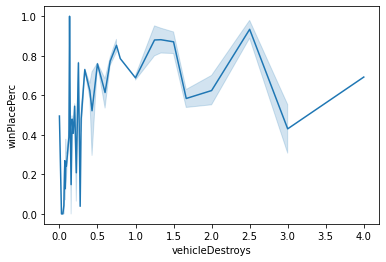

In [ ]:
g = sns.lineplot(x='vehicleDestroys', y="winPlacePerc", estimator=np.mean, data=team_df[team_df["vehicleDestroys"] <=5])

In [ ]:
sns.lineplot(x = range(int(team_df['vehicleDestroys'].max()) + 1, ), y=team_df[team_df['vehicleDestroys'] == i]['winPlacePerc'].values.mean())

    - 차량 파괴를 많이 할수록 승률이 상승하는것을 확인 할 수 있다.

    - 팀원이 늘어날수록 등수가 상승한다. ( 1명 대 4명 : 6%차이)

- 팀킬에 따른 등수 확인

In [ ]:
for i in range(int(team_df['teamKills'].max()) + 1):
    print('팀킬수 :', i, '\t', '평균 승률:', round(team_df[(team_df['teamKills']==i)]['winPlacePerc'].values.mean(),3))

팀킬수 : 0 	 평균 승률: 0.511
팀킬수 : 1 	 평균 승률: 0.538
팀킬수 : 2 	 평균 승률: 0.514
팀킬수 : 3 	 평균 승률: 0.521
팀킬수 : 4 	 평균 승률: 0.426


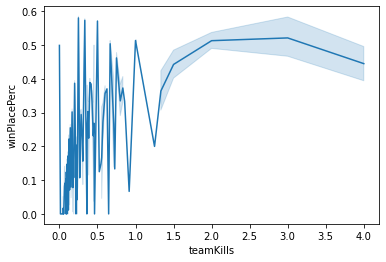

In [ ]:
g = sns.lineplot(x='teamKills', y="winPlacePerc", estimator=np.mean, data=team_df[team_df["teamKills"] <=5])

In [ ]:
for i in range(1, 5):
    print('팀킬수 :', i, '\t', '평균 팀원수 :', round(team_df[team_df['teamKills']==i]['team_members'].mean(),3),'\t', '팀수:',team_df[team_df['teamKills']==i].index.size)

팀킬수 : 1 	 평균 팀원수 : 1.296 	 팀수: 16477
팀킬수 : 2 	 평균 팀원수 : 1.026 	 팀수: 313
팀킬수 : 3 	 평균 팀원수 : 1.0 	 팀수: 43
팀킬수 : 4 	 평균 팀원수 : 1.143 	 팀수: 7


    - 팀 킬의 경우 실제 추치에 영향을 줄 data는 1킬 이나 
    - 수치가 평균 팀원수가 2가 아닌 1.3이 나와서 신뢰할 수 없는 수치로 확인되어 제외

### 팀원수에 다른 등수 확인

- 팀원수에 따른 등수 확인

In [ ]:
for i in range(1, int(team_df['team_members'].values.max())+1):
    if team_df[team_df['team_members']==i].index.get_level_values(0).nunique() !=0:
        print('팀원수 :', i, '\t','평균 승률:', round(team_df[team_df['team_members']==i]['winPlacePerc'].values.mean(), 3), '\t', '경기수 :',team_df[team_df['team_members']==i].index.get_level_values(0).nunique())

팀원수 : 1 	 평균 승률: 0.5 	 경기수 : 36621
팀원수 : 2 	 평균 승률: 0.522 	 경기수 : 37846
팀원수 : 3 	 평균 승률: 0.518 	 경기수 : 37500
팀원수 : 4 	 평균 승률: 0.548 	 경기수 : 33077
팀원수 : 5 	 평균 승률: 0.32 	 경기수 : 24293
팀원수 : 6 	 평균 승률: 0.248 	 경기수 : 16871
팀원수 : 7 	 평균 승률: 0.201 	 경기수 : 11504
팀원수 : 8 	 평균 승률: 0.161 	 경기수 : 7215
팀원수 : 9 	 평균 승률: 0.127 	 경기수 : 4336
팀원수 : 10 	 평균 승률: 0.102 	 경기수 : 2707
팀원수 : 11 	 평균 승률: 0.084 	 경기수 : 1696
팀원수 : 12 	 평균 승률: 0.07 	 경기수 : 1042
팀원수 : 13 	 평균 승률: 0.053 	 경기수 : 721
팀원수 : 14 	 평균 승률: 0.055 	 경기수 : 452
팀원수 : 15 	 평균 승률: 0.039 	 경기수 : 248
팀원수 : 16 	 평균 승률: 0.042 	 경기수 : 148
팀원수 : 17 	 평균 승률: 0.018 	 경기수 : 94
팀원수 : 18 	 평균 승률: 0.017 	 경기수 : 79
팀원수 : 19 	 평균 승률: 0.019 	 경기수 : 45
팀원수 : 20 	 평균 승률: 0.021 	 경기수 : 21
팀원수 : 21 	 평균 승률: 0.021 	 경기수 : 14
팀원수 : 22 	 평균 승률: 0.012 	 경기수 : 16
팀원수 : 23 	 평균 승률: 0.0 	 경기수 : 6
팀원수 : 24 	 평균 승률: 0.0 	 경기수 : 3
팀원수 : 25 	 평균 승률: 0.0 	 경기수 : 2
팀원수 : 26 	 평균 승률: 0.0 	 경기수 : 4
팀원수 : 27 	 평균 승률: 0.021 	 경기수 : 2
팀원수 : 28 	 평균 승률: 0.185 	 경기수 : 2
팀원수 : 31 	 평

In [ ]:
team_df[team_df['team_members']>4].index.get_level_values(0).nunique()

28500

- 팀원이 5명 이상인 팀수 

In [ ]:
team_df[team_df['team_members']>4].index.size

112057

- 팀원이 5명 이상인 팀이 참여한 경기수

In [ ]:
team_df[team_df['team_members']>4].index.get_level_values(0).nunique()

28500

팀전 전체 경기수

In [ ]:
team_df.index.get_level_values(0).nunique()

38889

### 경기내 팀 수에 따른 등수 예측 방법

### 관련 feature